In [90]:
import numpy as np
import gpflow
from gpflow.utilities import print_summary

# 生成数据
np.random.seed(42)
X = np.linspace(0, 150, 150).reshape(-1, 1)
Y = np.concatenate([np.zeros((50, 1)), np.ones((50, 1)), np.zeros((50, 1))]).reshape(-1, 1)
Y = 0.1 * np.random.randn(150).reshape(-1, 1) + Y

# 定义基本核函数
kernel1 = gpflow.kernels.Matern32()
kernel2 = gpflow.kernels.Matern32()
kernel3 = gpflow.kernels.Matern32()
kernel4 = gpflow.kernels.Matern32()

# 定义变点位置和陡度
locations = [0, 50, 100]  # 变点位置，可以是多个
steepness = 10.0   # 变点陡度

# 定义变点核函数
changepoint_kernel = gpflow.kernels.ChangePoints([kernel1, kernel2, kernel3, kernel4], locations=locations, steepness=steepness)

# 定义GP模型
model = gpflow.models.GPR(data=(X, Y), kernel=changepoint_kernel, mean_function=None)

# 优化模型
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

# 打印模型总结
changepoint_kernel.locations.numpy()


array([-119.73564802,   50.06902914,   99.67716953])

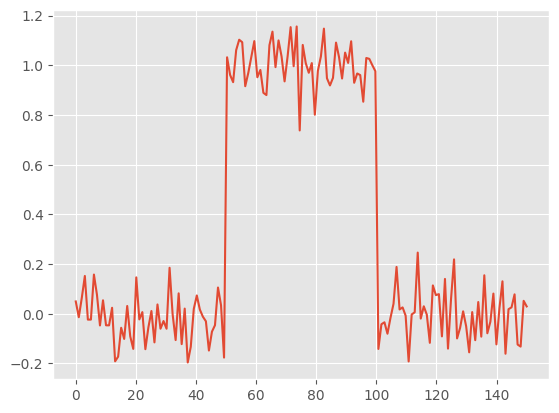

In [91]:
plt.plot(X, Y)

In [96]:
class ChangePointKernel(gpflow.kernels.Kernel):
    def __init__(self, k1, k2, location, steepness=1.0):
        super().__init__()
        self.k1 = k1
        self.k2 = k2
        self.location = location
        self.steepness = steepness

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        sig_X = self.sigmoid(X)
        sig_X2 = self.sigmoid(X2)
        k1_part = self.k1.K(X, X2) * (sig_X @ sig_X2.T)
        k2_part = self.k2.K(X, X2) * ((1 - sig_X) @ (1 - sig_X2).T)
        return k1_part + k2_part

    def K_diag(self, X):
        sig_X = self.sigmoid(X)
        k1_part = self.k1.K_diag(X) * (sig_X ** 2)
        k2_part = self.k2.K_diag(X) * ((1 - sig_X) ** 2)
        return k1_part + k2_part

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-self.steepness * (X - self.location)))
    
    
k1 = gpflow.kernels.Matern32()
k2 = gpflow.kernels.RBF()
location = 50  # 假设变点位置在50
steepness = 1.0

change_point_kernel = ChangePointKernel(k1, k2, location, steepness)
gpr_model = gpflow.models.GPR(data=(X, Y), kernel=change_point_kernel)

opt = gpflow.optimizers.Scipy()
opt.minimize(gpr_model.training_loss, variables=gpr_model.trainable_variables)


In [100]:
import numpy as np
import gpflow

# 生成示例数据
X = np.random.rand(100, 1) * 100  # 生成随机数据
Y = np.sin(X) + np.random.randn(100, 1) * 0.1  # 添加噪声的sin函数

# 使用单一核函数，例如Matern32
single_kernel = gpflow.kernels.Matern32()

# 构建高斯过程模型
gpr_model_single = gpflow.models.GPR(data=(X, Y), kernel=single_kernel)

# 优化模型
opt = gpflow.optimizers.Scipy()
opt.minimize(gpr_model_single.training_loss, variables=gpr_model_single.trainable_variables)

print_summary(single_kernel)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ Matern32.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.524651 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Matern32.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.4001   │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧══════════╛


In [99]:
import numpy as np
import gpflow

class ChangePointKernel(gpflow.kernels.Kernel):
    def __init__(self, k1, k2, location, steepness=1.0):
        super().__init__()
        self.k1 = k1
        self.k2 = k2
        self.location = location
        self.steepness = steepness

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        sig_X = self.sigmoid(X)
        sig_X2 = self.sigmoid(X2)
        k1_part = self.k1.K(X, X2) * (sig_X @ sig_X2.T)
        k2_part = self.k2.K(X, X2) * ((1 - sig_X) @ (1 - sig_X2).T)
        return k1_part + k2_part

    def K_diag(self, X):
        sig_X = self.sigmoid(X)
        k1_part = self.k1.K_diag(X) * (sig_X ** 2)
        k2_part = self.k2.K_diag(X) * ((1 - sig_X) ** 2)
        return k1_part + k2_part

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-self.steepness * (X - self.location)))

# 定义两个核函数
k1 = gpflow.kernels.Matern32()
k2 = gpflow.kernels.RBF()
location = 50  # 假设变点位置在50
steepness = 1.0

# 实例化变点核函数
change_point_kernel = ChangePointKernel(k1, k2, location, steepness)

# 构建高斯过程模型
gpr_model_change_point = gpflow.models.GPR(data=(X, Y), kernel=change_point_kernel)

# 优化模型
opt = gpflow.optimizers.Scipy()
opt.minimize(gpr_model_change_point.training_loss, variables=gpr_model_change_point.trainable_variables)


NotImplementedError: in user code:

    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\optimizers\scipy.py", line 192, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\optimizers\scipy.py", line 329, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\integration\tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\models\training_mixins.py", line 64, in training_loss  *
        return self._training_loss()  # type: ignore[attr-defined]
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\integration\tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\models\model.py", line 76, in _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\integration\tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\models\gpr.py", line 86, in maximum_log_likelihood_objective  *
        return self.log_marginal_likelihood()
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\integration\tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\models\gpr.py", line 100, in log_marginal_likelihood  *
        K = self.kernel(X)
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\integration\tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\check_shapes\decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "c:\Users\jrfundoffice02\anaconda3\envs\xtrend-env\Lib\site-packages\gpflow\kernels\base.py", line 214, in __call__  *
        return self.K(X, X2)
    File "C:\Users\jrfundoffice02\AppData\Local\Temp\ipykernel_5880\2572855797.py", line 15, in K  *
        sig_X = self.sigmoid(X)
    File "C:\Users\jrfundoffice02\AppData\Local\Temp\ipykernel_5880\2572855797.py", line 28, in sigmoid  *
        return 1 / (1 + np.exp(-self.steepness * (X - self.location)))

    NotImplementedError: Cannot convert a symbolic tf.Tensor (mul:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [ ]:
nlml_single = gpr_model_single.training_loss().numpy()
nlml_change_point = gpr_model_change_point.training_loss().numpy()

print(f"NLML without change point kernel: {nlml_single}")
print(f"NLML with change point kernel: {nlml_change_point}")
